# **CML1 Project 1: Linear Models**
*Student: Mathias Schindler*

*Date of Submission: Nov 7, 2021*

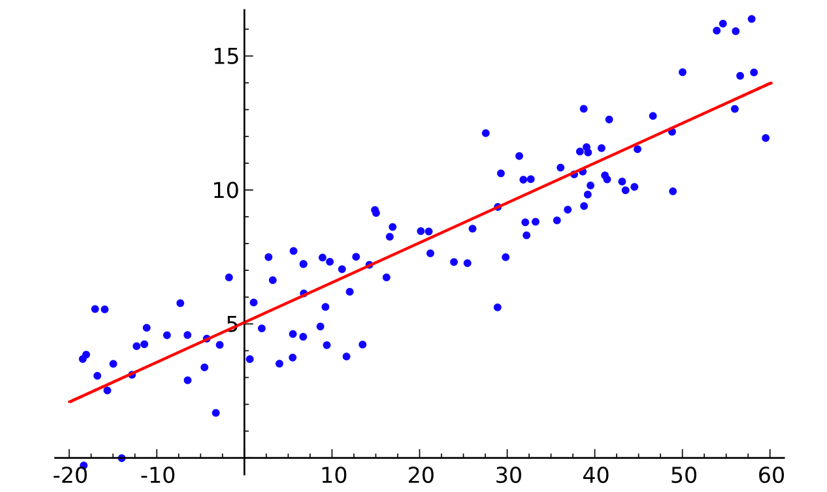

# *Preamble*

In [ ]:
#Preamble
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
import sklearn

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Inspection & Preparation**

## Loading data

In [ ]:
#Load data
# Specify 'index_col' so "lotid" is not treated as predictor in fitted models
train_raw = pd.read_csv("Regression_Supervised_Train.csv", index_col = "lotid")
test_raw = pd.read_csv("Regression_Supervised_Test_updated.csv", index_col = "lotid")
print(train_raw.head(10))
print(test_raw.head(10))

          logerror transactiondate  ...  taxdelinquencyyear  mypointer
lotid                               ...                               
17214744       NaN             NaN  ...                 NaN      25711
12018724       NaN             NaN  ...                 NaN      13268
11306699       NaN             NaN  ...                11.0       5423
11047729       NaN             NaN  ...                 NaN      26198
17174848       NaN             NaN  ...                 NaN      25187
14305657       NaN             NaN  ...                 NaN       6066
11016338       NaN             NaN  ...                 NaN       4138
13961339       NaN             NaN  ...                 NaN       4706
11671803       NaN             NaN  ...                 NaN       5706
11150386       NaN             NaN  ...                 NaN      13350

[10 rows x 47 columns]
          logerror transactiondate  ...  taxdelinquencyflag  taxdelinquencyyear
lotid                               ...     

## Introductory Data Preparation

First, the features $totaltaxvalue$, $buildvalue$ or $landvalue$ are removed from the training and test dataset, and also $mypointer$ from the training set as specified in the instructions. \\
Then the data structure, in regards of missing values, is inspected.

In [ ]:
def make_nan_fig(df, title):
  nan_df = df.isnull().sum()/len(df)*100
  nan_df = nan_df.sort_values(ascending = False)

  nan_df_fig = plt.bar(nan_df.index, nan_df.values)
  plt.xticks(rotation='vertical', fontsize = 12)
  plt.ylabel('% NaN', fontsize = 12)
  plt.hlines(y=40, xmin= 0, xmax = 40, linestyle = 'dashed')
  plt.title('NaN data in ' + title + ' dataset as proportion of total observations')
  fig = plt.gcf()
  fig.set_size_inches(18, 5)
  plt.show()
  return nan_df_fig


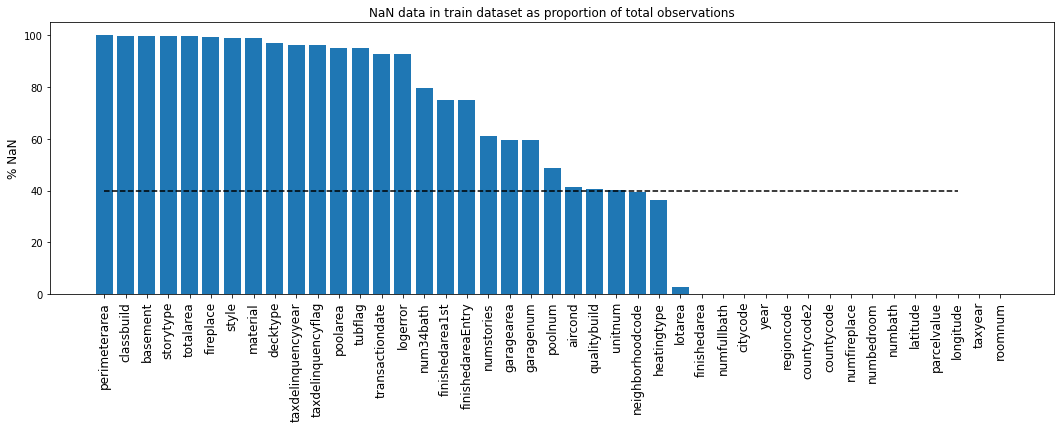

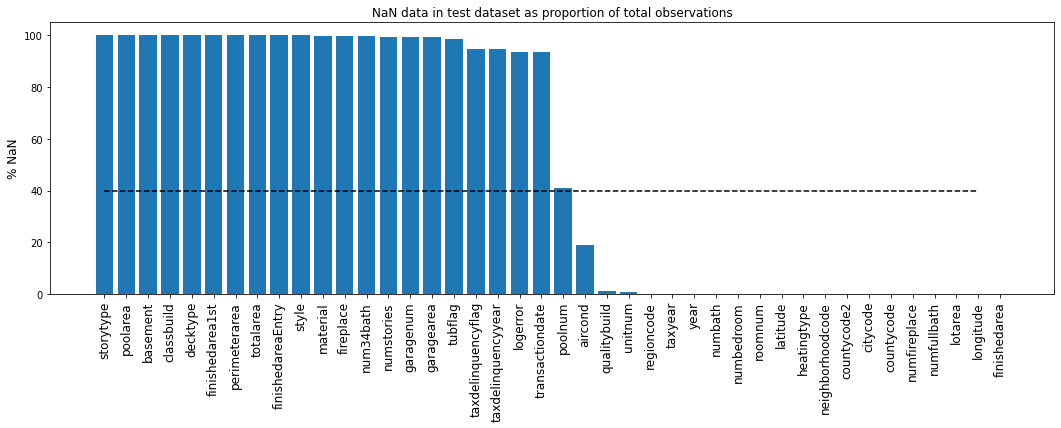

<BarContainer object of 42 artists>

In [ ]:
del_feats = ["totaltaxvalue", "buildvalue", "landvalue", "mypointer"]
train_clean = train_raw.drop(del_feats, axis = 1)
test_clean = test_raw.drop(del_feats[0:3], axis = 1)

# Inspect missing data
make_nan_fig(train_clean, "train")
make_nan_fig(test_clean, "test")

So, there is a substantial amount of missing data in both the training and testing dataset. In the training data set we see, that there are 3 variables just over the threshold of 40%. 

## Imputing Missing Values for Some Features

All features in the training data for which missing values are imputed have to be transformed in the same way in the testing data. This naturally limits the possibility frontier. \\
>From the above bar plot showing percentages of missing data, in the testing data it is seen that $poolnum$ has around 40 pct. missing values while the comparably feature with next-lowst percantage of missing values is $transactiondate$ with around 90 pct. For features with 90 pct. missing values, I do not consider it sensible to impute values as it would be ambiguous as to which method of imputation would be appropriate for these given features.

In [ ]:
# Finding the features to impute
na_test = test_clean.isnull().sum()/len(test_clean)*100
na_test = na_test.sort_values(ascending = False)

fillna_feat = na_test[na_test.between(0.001, 60)].index
fillna_feat

Index(['poolnum', 'aircond', 'qualitybuild', 'unitnum'], dtype='object')

So the features that will have imputed values in the datasets are $[poolnum, aircond, qualitybuild, unitnum]$. Here $aircond$ is a categorical variable while the other three are numerical variables. For numerical variables, i.e. $poolnum, qualitybuild, unitnum$, it is most appropriate to impute using the mean of the variables while for the categorical $aircond$ it makes most sense to use the most frequent value (because a non-integer value for a categorical variable would be undefined).

In [ ]:
from sklearn.impute import SimpleImputer

#Instantiate SimpleImputer
imp_mn = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


## FOR THE TRAIN DATA  
train_imp_mn = train_clean[['poolnum', 'qualitybuild', 'unitnum']]
train_imp_mf = train_clean[['aircond']]

#Fit and transform
train_imp_mn = imp_mn.fit_transform(train_imp_mn)
train_imp_mn = pd.DataFrame(train_imp_mn, columns = ['poolnum', 'qualitybuild', 'unitnum'], index = train_clean.index)

train_imp_mf = imp_mf.fit_transform(train_imp_mf)
train_imp_mf = pd.DataFrame(train_imp_mf, columns = ['aircond'], index = train_clean.index)

train_imp = pd.concat([train_imp_mn, train_imp_mf], axis=1) 


## FOR THE TEST DATA  
test_imp_mn = test_clean[['poolnum', 'qualitybuild', 'unitnum']]
test_imp_mf = test_clean[['aircond']]

#Fit and transform
test_imp_mn = imp_mn.fit_transform(test_imp_mn)
test_imp_mn = pd.DataFrame(test_imp_mn, columns = ['poolnum', 'qualitybuild', 'unitnum'], index = test_clean.index)

test_imp_mf = imp_mf.fit_transform(test_imp_mf)
test_imp_mf = pd.DataFrame(test_imp_mf, columns = ['aircond'], index = test_clean.index)

test_imp = pd.concat([test_imp_mn, test_imp_mf], axis=1) 

In [ ]:
print(train_clean[['poolnum', 'qualitybuild', 'unitnum', 'aircond']].value_counts())
print(train_imp.value_counts())

print(test_clean[['poolnum', 'qualitybuild', 'unitnum', 'aircond']].value_counts())
print(test_imp.value_counts())

poolnum  qualitybuild  unitnum  aircond
1.0      4.0           1.0      1.0        2845
         7.0           1.0      1.0        1460
         8.0           1.0      1.0        1320
         6.0           1.0      1.0         473
         1.0           1.0      1.0         367
         10.0          1.0      1.0         364
         9.0           1.0      1.0         278
         11.0          1.0      1.0         157
         12.0          1.0      1.0          78
         4.0           2.0      1.0           3
         6.0           2.0      1.0           2
         7.0           2.0      1.0           1
         6.0           4.0      1.0           1
dtype: int64
poolnum  qualitybuild  unitnum  aircond
1.0      5.640235      1.0063   1.0        8483
         4.000000      1.0000   1.0        6470
         7.000000      1.0000   1.0        3813
         8.000000      1.0000   1.0        1662
         5.640235      1.0063   13.0       1203
         1.000000      1.0000   1.0        

In [ ]:
# Add features with imputed values 

#To training data
train_clean = train_clean.drop(['poolnum', 'qualitybuild', 'unitnum', 'aircond'], axis = 1)
train_clean = pd.concat([train_clean, train_imp], axis = 1)

#To testing data
test_clean = test_clean.drop(['poolnum', 'qualitybuild', 'unitnum', 'aircond'], axis = 1)
test_clean = pd.concat([test_clean, test_imp], axis = 1)

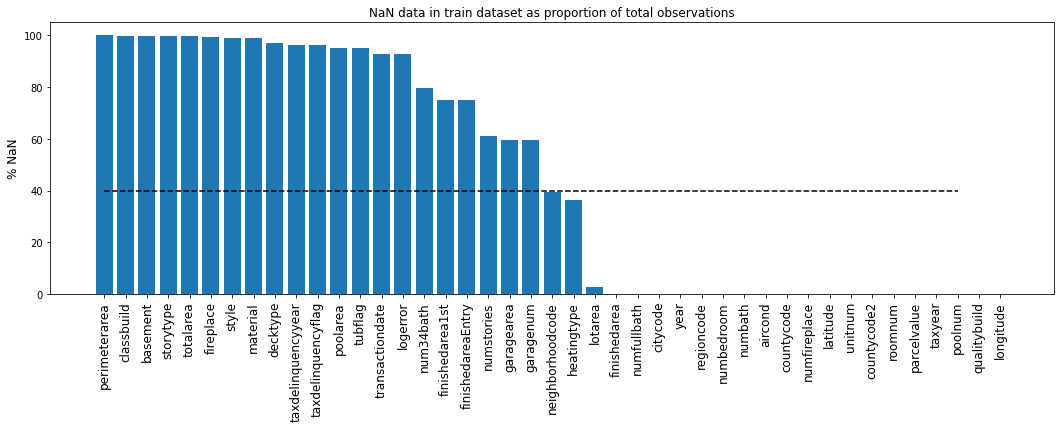

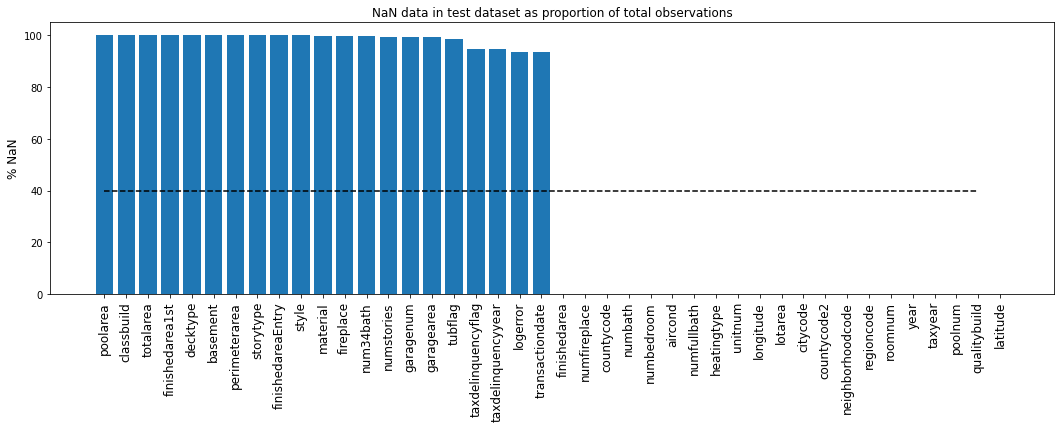

<BarContainer object of 42 artists>

In [ ]:
#Reproduce previous figures for missing data
make_nan_fig(train_clean, "train")
make_nan_fig(test_clean, "test")

In [ ]:
# Columns in test w. <50% NaN
na_test = test_clean.isnull().sum()/len(test_clean)*100
na_test = na_test.sort_values(ascending = False)
na_test_u50 = na_test[na_test<50]
test_u50_col = na_test_u50.index

# Columns in training dataset
train_col = train_clean.columns

# Difference
test_u50_col.difference(train_col) #None

Index([], dtype='object')

## Removing Features w. >40% NaN

In [ ]:
# Remove features w. >40% NaN
mypct = 0.6
train_clean = train_clean.dropna(axis = 1, thresh = round(mypct*len(train_clean.index)))
test_clean = test_clean.dropna(axis = 1, thresh = round(mypct*len(test_clean.index)))

# Remove rows w. any NaN
train_clean = train_clean.dropna(axis = 0)

print(train_clean.shape)
print(test_clean.shape)

(12560, 22)
(2746, 21)


In [ ]:
# Check difference in columns
def col_diff(df1, df2):
  df1_col = df1.columns
  df2_col = df2.columns

  print("Columns in " + df1.name + " that are not in " + df2.name + ":")
  print(df1_col.difference(df2_col))
  print("\n")
  print("Columns in " + df2.name + " that are not in " + df1.name + ":")
  print(df2_col.difference(df1_col)) 

train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean) #No difference


Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')


## Dealing with Categorical Features

From the $Case\_data\_dictionary.xlsx$-file the following features do not have a natural ordering and are hence considered categorical:


*   $aircond$
*   $style$
*   $classbuild$
*   $countycode$
*   $fireplace$
*   $tubflag$
*   $heatingtype$
*   $countycode2$
*   $citycode$
*   $regioncode$
*   $neighborhoodcode$
*   $storytype$
*   $material$




In [ ]:
cat_feat = ['aircond', 'style', 'classbuild', 'countycode', 'fireplace', 'tubflag', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode', 'storytype', 'material']

def is_in_df(vars, df, df_style):
  vars_in_df = []
  for i in vars:
    if i in df.columns:
        print("Yes, " + str(i) + " is in " + df_style)
        vars_in_df.append(i)
    else:
        print("No, " + str(i) + " is not in " + df_style)
  print(vars_in_df)
  return vars_in_df

# I run the function on train and test so make sure they are the same
print("Train:")
cat_feat_train = is_in_df(cat_feat, train_clean, "train")
print("\n Test:")
cat_feat_test = is_in_df(cat_feat, test_clean, "test")

Train:
Yes, aircond is in train
No, style is not in train
No, classbuild is not in train
Yes, countycode is in train
No, fireplace is not in train
No, tubflag is not in train
Yes, heatingtype is in train
Yes, countycode2 is in train
Yes, citycode is in train
Yes, regioncode is in train
Yes, neighborhoodcode is in train
No, storytype is not in train
No, material is not in train
['aircond', 'countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']

 Test:
Yes, aircond is in test
No, style is not in test
No, classbuild is not in test
Yes, countycode is in test
No, fireplace is not in test
No, tubflag is not in test
Yes, heatingtype is in test
Yes, countycode2 is in test
Yes, citycode is in test
Yes, regioncode is in test
Yes, neighborhoodcode is in test
No, storytype is not in test
No, material is not in test
['aircond', 'countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']


In [ ]:
# Inspect the unique values of each categorical feature
for q in ["train_clean", "test_clean"]:
  print(str(q) + "\n" + "-----------------------------------------------------------------------------------")
  if q == "train_clean":
    for i in cat_feat_train:
      print(str(i) + "\n")
      print(train_clean[i].value_counts())
  else:
    for i in cat_feat_test:
      print(str(i) + "\n")
      print(test_clean[i].value_counts())  
  print("\n\n")

# Features "aircond", "countycode", "countycode2", and "heatingtype" have very little variation
# "Citycode", "regioncode" and "neighborhoodcode" have variation

train_clean
-----------------------------------------------------------------------------------
aircond

1.0     12516
5.0        35
11.0        6
13.0        3
Name: aircond, dtype: int64
countycode

6037    12445
6059      115
Name: countycode, dtype: int64
heatingtype

2.0     11621
7.0       830
6.0        99
20.0        9
18.0        1
Name: heatingtype, dtype: int64
countycode2

3101    12445
1286      115
Name: countycode2, dtype: int64
citycode

12447.0     8730
54311.0     1219
46298.0      610
45457.0      556
47019.0      457
54722.0      179
9840.0       133
30908.0       92
54299.0       88
39308.0       79
26964.0       71
16764.0       70
51617.0       52
51861.0       48
37688.0       44
396054.0      38
47568.0       22
52650.0       22
48424.0       16
12520.0       11
42150.0       11
33612.0       11
53571.0        1
Name: citycode, dtype: int64
regioncode

96389.0    414
96364.0    335
96379.0    322
96356.0    320
96339.0    298
          ... 
96212.0      1
96217

Now I create dummies for the categorical features. Although $regioncode$ and $neighborhoodcode$ are categorical features there are too many instances where the unique codes are different in the training and testing dataset, respectively. Hence, they will not be transformed with dummies.

In [ ]:
# Creating dummies for categorical variables:
train_clean = pd.get_dummies(train_clean, prefix=['ac_'], columns=['aircond'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['county_'], columns=['countycode'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['county2_'], columns=['countycode2'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['heat_'], columns=['heatingtype'], drop_first = True)
train_clean = pd.get_dummies(train_clean, prefix=['city_'], columns=['citycode'], drop_first = True)
#train_clean = pd.get_dummies(train_clean, prefix=['region_'], columns=['regioncode'], drop_first = True)
#train_clean = pd.get_dummies(train_clean, prefix=['nbhd_'], columns=['neighborhoodcode'], drop_first = True)

test_clean = pd.get_dummies(test_clean, prefix=['ac_'], columns=['aircond'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['county_'], columns=['countycode'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['county2_'], columns=['countycode2'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['heat_'], columns=['heatingtype'], drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=['city_'], columns=['citycode'], drop_first = True)
#test_clean = pd.get_dummies(test_clean, prefix=['region_'], columns=['regioncode'], drop_first = True)
#test_clean = pd.get_dummies(test_clean, prefix=['nbhd_'], columns=['neighborhoodcode'], drop_first = True)

In [ ]:
# Check difference in columns
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean)

#Value counts of the differences in features:
print("\n\n")
for i in [["ac__13.0", "city__53571.0", "heat__18.0"]]:
  print(train_clean[i].value_counts())

Columns in train that are not in test:
Index(['ac__13.0', 'city__53571.0', 'heat__18.0', 'parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')



ac__13.0  city__53571.0  heat__18.0
0         0              0             12555
1         0              0                 3
0         1              0                 1
          0              1                 1
dtype: int64


Deleting $aircond==13$; $citycode==53571$ and $heatingtype==18$ only reduces the training dataset with at most five observations while making sure that the columns are the same across the training and testing dataset. These few observations should not change the results much. In this case, I therefore determine that the benefits outweight the costs of removing these columns from the training dataset:

In [ ]:
for i in ["ac__13.0", "city__53571.0", "heat__18.0"]:
  train_clean = train_clean.drop(i, axis = 1)

In [ ]:
#Final check of comparison
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean) #No diff

Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')


Now, the data is split into the dependent variable $parcelvalue$ and its predictors:

In [ ]:
y = train_clean["parcelvalue"]
x = train_clean.drop("parcelvalue", axis=1)

## Polynomial Features

<u>Note to self</u> \\
Success with the following model:
*   Only non-dummy features transformed (degree 3) 

No success in Kaggle-scores with polynomial features for following models:

*   ~~All features polynomial transformed (degree 2)~~
*   ~~Only non-dummy features transformed (degree 2)~~
*   ~~Only non-dummy features transformed (degree >=4) ~~ *(scored absolutely terrible)*
*   Topscorer degree also with non-dummy features


In [ ]:
from sklearn.preprocessing import PolynomialFeatures as plf

# Set degree
degree = 3

# Instantiate 
poly = plf(degree, include_bias = False)

# For both train and test dataset:
#for k in [x, test_clean]:
  # Fit and transform features
#  k = poly.fit_transform(k)

  # Add feature names 
 # poly_col_names = poly.get_feature_names(train_clean.columns)
  #k = pd.DataFrame(k, columns = poly_col_names)

In [ ]:
# TRAIN
x_poly = x.iloc[:,0:16]
#poly_col_names = poly.get_feature_names(x_poly.columns)

# Fit and transform features
x_poly = poly.fit_transform(x_poly)

# Add feature names 
#x_poly = pd.DataFrame(x_poly, columns = poly_col_names, index = train_clean.index)
x_poly = pd.DataFrame(x_poly, index = train_clean.index)
print(x_poly.shape)

# Put training dataset back together
x = pd.concat([x.iloc[:,16:], x_poly], axis = 1)
#x

(12560, 968)


In [ ]:
# TEST
test_poly = test_clean.iloc[:,0:16]
test_clean_idx = test_clean.index
test_poly_col_names = poly.get_feature_names(test_poly.columns)

# Fit and transform features
test_poly = poly.fit_transform(test_poly)

# Add feature names 
test_poly = pd.DataFrame(test_poly, columns = test_poly_col_names, index = test_clean_idx)
print(test_poly.shape)

# Put training dataset back together
test_clean = pd.concat([test_clean.iloc[:,16:], test_poly], axis = 1)
#test_clean

(2746, 968)


# **Baseline OLS Predictions**

First, baseline OLS regression is run:

In [ ]:
from sklearn.linear_model import LinearRegression

# Instantiate model
regr = LinearRegression()

# Fit model
coef_OLS = regr.fit(x,y).coef_

# Display parameter estimates
list(map('{:.7f}'.format,coef_OLS))

['0.0012395',
 '-0.0015303',
 '0.0000990',
 '-0.0021766',
 '-0.0000031',
 '0.0003626',
 '-0.0000639',
 '-0.0000729',
 '0.0002746',
 '-0.0004226',
 '0.0005605',
 '0.0001329',
 '0.0000592',
 '-0.0000165',
 '-0.0000079',
 '0.0000151',
 '-0.0000035',
 '0.0000038',
 '-0.0000074',
 '0.0000194',
 '0.0000303',
 '0.0000285',
 '-0.0000108',
 '0.0000369',
 '0.0000310',
 '-0.0000016',
 '0.0000003',
 '-0.0000327',
 '-0.0000443',
 '-0.0000287',
 '0.0000298',
 '0.0000100',
 '-0.0000133',
 '0.0000000',
 '0.0000000',
 '0.0000000',
 '0.0000000',
 '0.0000000',
 '-0.0000000',
 '-0.0000000',
 '-0.0000000',
 '0.0000000',
 '-0.0000000',
 '-0.0000000',
 '-0.0000000',
 '0.0000000',
 '0.0000000',
 '0.0000000',
 '-0.0000000',
 '-0.0000012',
 '0.0000041',
 '-0.0000000',
 '0.0000000',
 '-0.0000000',
 '0.0000000',
 '-0.0000000',
 '-0.0000000',
 '-0.0000000',
 '-0.0000000',
 '-0.0000000',
 '0.0000000',
 '0.0000000',
 '-0.0000000',
 '0.0000000',
 '0.0000012',
 '-0.0000040',
 '-0.0000000',
 '0.0000000',
 '0.0000000',


In [ ]:
# Produce predictions using test dataset
y_hat_test = regr.predict(test_clean)
y_hat_test

array([520325.91696167, 631530.97692108, 224509.76002884, ...,
       439602.24399567, 353068.43508148, 441288.00272751])

In [ ]:
#sum(i<0 for i in y_hat_test )/len(y_hat_test )*100 

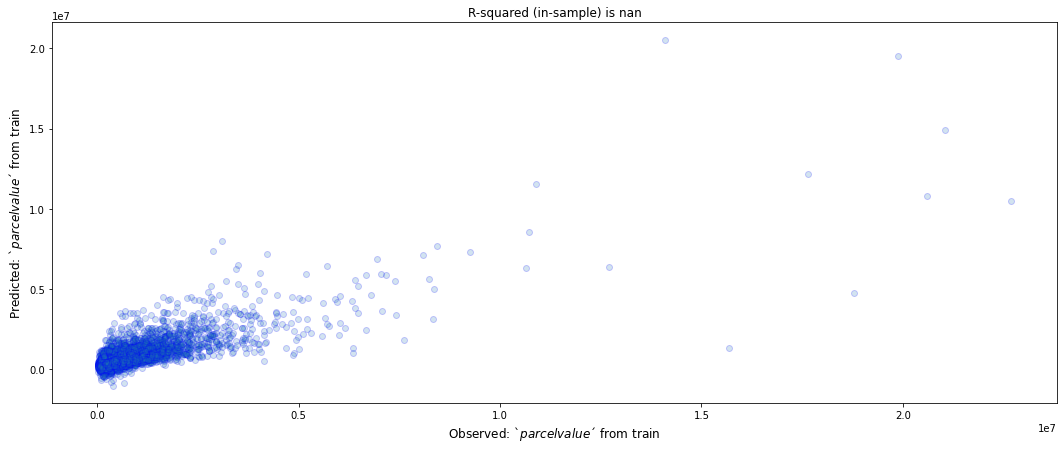

In [ ]:
# Visualizing predictions in-sample
y_hat_insample = regr.predict(x)

pd_y_hat_insample, pd_y = pd.Series(y_hat_insample), pd.Series(y)

#pears = pd_y.corr(pd_y_hat_insample)

def accuracy_fig(y_train, y_pred, pred_type):
  plt.figure()
  plt.scatter(x=y_train,y=y_pred, alpha=0.2, edgecolors='b')   
  plt.xlabel('Observed: `$parcelvalue$´ from train', fontsize = 12)
  plt.ylabel('Predicted: `$parcelvalue$´ from train', fontsize = 12)
  plt.title("R-squared (" +  pred_type + ") is " + "{:.9f}".format((pd_y.corr(pd_y_hat_insample))**2) )
  pred_fig = plt.gcf()
  pred_fig.set_size_inches(18, 7)
  plt.show()

accuracy_fig(y, y_hat_insample, "in-sample")

Estimating out-of-sample accuracy employing cross-validation. A 10-fold splitting strategy is chosen for computational efficiency (relative to the leave-one-out strategy):

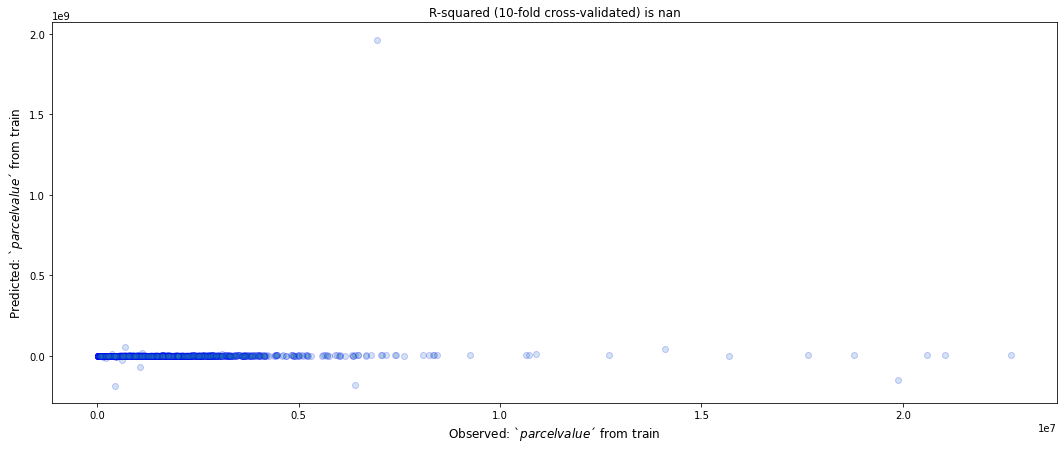

In [ ]:
from sklearn.model_selection import cross_val_predict as cvp

y_hat_cv = cvp(regr, x, y, cv=10)

pd_y_hat_cv, pd_y = pd.Series(y_hat_cv), pd.Series(y)
pears = pd_y.corr(pd_y_hat_cv)

accuracy_fig(y, y_hat_cv, "10-fold cross-validated")

# **LASSO**

## Baseline LASSO Model

For LASSO it is essential to scale predictors:

In [ ]:
from sklearn import preprocessing

# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to training set
scaler.fit(x)

# Transform training and testing data based on values of training set (no refit to test data, just transforming):
x_scaled = scaler.transform(x)

test_scaled = scaler.transform(test_clean)

First, a baseline LASSO model is run before optimizing hyperparameters.

In [215]:
from sklearn.linear_model import Lasso

# Instantiate Lasso
regr_lasso = Lasso(alpha = 100000, fit_intercept=False, warm_start=True, max_iter= 1000)
#regr_lasso = Lasso(alpha=0.5, fit_intercept=False,warm_start=True,max_iter=1000000)

# Fit Lasso
regr_lasso.fit(x_scaled,y)  # Run time: 3m 56s [non-scaled, Poly.degree = 3 (ca. 1,000 features), max_iter = 10,000]
                            # Run time: 13s [scaled, Poly.degree = 3 (ca. 1,000 features), max_iter = 10,000]

# Display parameter coefficients
coef_OLS = regr_lasso.coef_
#list(map('{:.7f}'.format, coef_OLS))

In [216]:
# Produce predictions using test dataset
y_hat_lasso_test = regr_lasso.predict(test_scaled)
y_hat_lasso_test

array([ -46830.05305781,  -25825.43702625, -202974.49088407, ...,
       -120672.66871272, -212597.04772657, -130916.99212813])

In [217]:
sum(i<0 for i in y_hat_lasso_test )/len(y_hat_lasso_test)*100 

63.00072833211945

# **Exporting Predictions for Kaggle-Submission**

Lastly, the predicted values of $parcelvalue$ along with its identifier $lotid$ are exorted to a .csv-file suitably formatted for Kaggle.

In [ ]:
# .csv for Kaggle-submission
submission = pd.DataFrame({"lotid": test_clean.index, "parcelvalue": y_hat_lasso_test})
print(submission.shape)
submission.to_csv("/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Predictions/pred13_lasso_nonscaled.csv", index = False)

(2746, 2)
